In [1]:
import kagglehub

path = kagglehub.dataset_download("ishanikathuria/handwritten-signature-datasets")

print("Path to dataset files:", path)

100%|██████████| 290M/290M [00:02<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ishanikathuria/handwritten-signature-datasets/versions/3


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda

In [3]:
bengali_directory = os.path.join(path, 'BHSig260-Bengali/BHSig260-Bengali')
hindi_directory = os.path.join(path, 'BHSig260-Hindi/BHSig260-Hindi')
cedar_directory = os.path.join(path, 'CEDAR/CEDAR')


In [4]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess image with error handling"""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, target_size)  # Resize to VGG16 input size

    # Apply Gaussian blur to reduce noise
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Thresholding to highlight signature
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Convert to array and expand dimensions for batch processing by preprocess_input
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Apply VGG16 preprocessing function
    img = preprocess_input(img)

    return img[0]  # Remove batch dimension

In [17]:
def load_dataset(dataset_path):
    """Load and prepare dataset for training with robust error handling"""
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset path not found: {dataset_path}")

    person_dirs = [d for d in os.listdir(dataset_path)
                  if os.path.isdir(os.path.join(dataset_path, d))]

    if not person_dirs:
        raise ValueError(f"No person directories found in {dataset_path}")

    person_dirs = sorted(person_dirs)

    pairs = []
    labels = []

    for person_dir in person_dirs:
        full_path = os.path.join(dataset_path, person_dir)

        image_files = os.listdir(full_path)
        genuine_files = [f for f in image_files if 'G' in f or 'original' in f]
        forged_files = [f for f in image_files if 'F' in f or 'forgeries' in f]

        if not genuine_files or not forged_files:
            print(f"Warning: Missing genuine or forged files for {person_dir}")
            continue
        for i in range(len(genuine_files)):
            for j in range(i + 1, len(genuine_files)):
                try:
                    anchor = load_and_preprocess_image(os.path.join(full_path, genuine_files[i]))
                    positive = load_and_preprocess_image(os.path.join(full_path, genuine_files[j]))
                    pairs.append([anchor, positive])
                    labels.append(1)
                except Exception as e:
                    print(f"Error processing positive pair: {e}")
                    continue

        for i in range(min(len(genuine_files), len(forged_files))):
            try:
                anchor = load_and_preprocess_image(os.path.join(full_path, genuine_files[i]))
                negative = load_and_preprocess_image(os.path.join(full_path, forged_files[i]))
                pairs.append([anchor, negative])
                labels.append(0)
            except Exception as e:
                print(f"Error processing negative pair: {e}")
                continue

    if not pairs:
        raise ValueError(f"No valid pairs could be created from {dataset_path}")

    pairs = np.array(pairs)
    labels = np.array(labels)

    train_pairs, test_pairs, train_labels, test_labels = train_test_split(
        pairs, labels, test_size=0.2, random_state=42
    )

    train_pairs, val_pairs, train_labels, val_labels = train_test_split(
        train_pairs, train_labels, test_size=0.2, random_state=42
    )

    return (train_pairs, train_labels), (val_pairs, val_labels), (test_pairs, test_labels)

In [6]:
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE

In [7]:
def create_data_generators(train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels, batch_size=BATCH_SIZE):
    """Create data generators for training and validation."""
    train_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_layer_1': train_pairs[:, 0],
            'input_layer_2': train_pairs[:, 1]
        },
        train_labels
    )).shuffle(128).batch(batch_size).prefetch(AUTO)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_layer_1': val_pairs[:, 0],
            'input_layer_2': val_pairs[:, 1]
        },
        val_labels
    )).batch(batch_size).prefetch(AUTO)

    test_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_layer_1': test_pairs[:, 0],
            'input_layer_2': test_pairs[:, 1]
        },
        test_labels
    )).batch(batch_size).prefetch(AUTO)

    return train_dataset, val_dataset, test_dataset

In [8]:
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [9]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1 - y_true) * square_pred + y_true * margin_square)

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
embedding = Dense(128)(x)

embedding_model = Model(base_model.input, embedding)

input_1 = Input(shape=(224, 224, 3))
input_2 = Input(shape=(224, 224, 3))

embedding_1 = embedding_model(input_1)
embedding_2 = embedding_model(input_2)

distance = Lambda(euclidean_distance)([embedding_1, embedding_2])

predictions = Dense(1, activation='sigmoid')(distance)

siamese_model = Model(inputs=[input_1, input_2], outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
siamese_model.compile(optimizer='adam', metrics=['accuracy'], loss = contrastive_loss)

In [12]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

In [13]:
cedar_train, cedar_val, cedar_test = load_dataset(cedar_directory)

cedar_train_gen, cedar_val_gen, cedar_test_gen = create_data_generators(
    cedar_train[0], cedar_train[1],
    cedar_val[0], cedar_val[1],
    cedar_test[0], cedar_test[1]
)

In [14]:
history3 = siamese_model.fit(
    cedar_train_gen,
    validation_data=cedar_val_gen,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 519ms/step - accuracy: 0.9281 - loss: 0.1133 - val_accuracy: 0.9435 - val_loss: 0.0916 - learning_rate: 0.0010
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 286ms/step - accuracy: 0.9235 - loss: 0.1123 - val_accuracy: 0.9435 - val_loss: 0.0899 - learning_rate: 0.0010
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 299ms/step - accuracy: 0.9253 - loss: 0.1099 - val_accuracy: 0.9435 - val_loss: 0.0883 - learning_rate: 0.0010
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 301ms/step - accuracy: 0.9247 - loss: 0.1066 - val_accuracy: 0.9435 - val_loss: 0.0872 - learning_rate: 0.0010
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - accuracy: 0.9199 - loss: 0.1094 - val_accuracy: 0.9435 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 307ms/step - accuracy: 0.9261 - loss: 0.1037 - val_accuracy: 0.9435 - val_loss: 0.0845 - learning_rate: 0.0010
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - accuracy: 0.9269 - loss: 0.

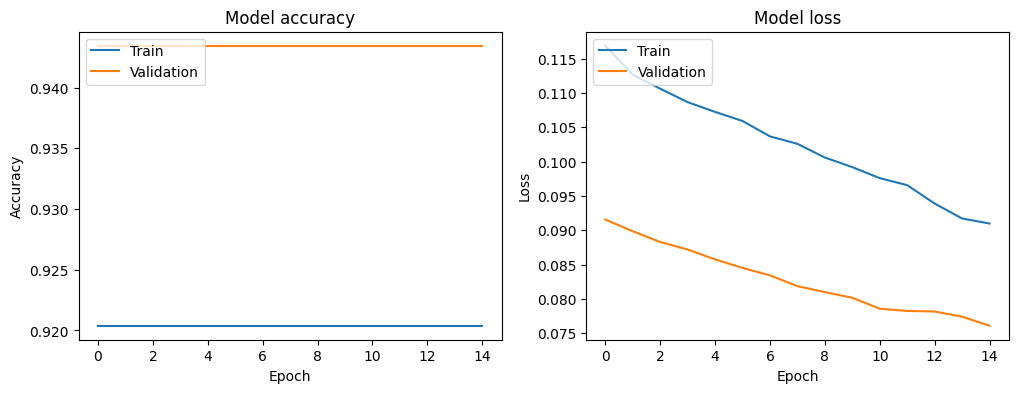

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [16]:
loss3, accuracy3 = siamese_model.evaluate(cedar_test_gen)
print(f"Test Loss: {loss3}")
print(f"Test Accuracy: {accuracy3}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 543ms/step - accuracy: 0.9073 - loss: 0.1065
Test Loss: 0.11352253705263138
Test Accuracy: 0.8999999761581421


In [18]:
bengali_train, bengali_val, bengali_test = load_dataset(bengali_directory)

bengali_train_gen, bengali_val_gen, bengali_test_gen = create_data_generators(
    bengali_train[0], bengali_train[1],
    bengali_val[0], bengali_val[1],
    bengali_test[0], bengali_test[1]
)

In [19]:
loss1, accuracy1 = siamese_model.evaluate(bengali_test_gen)
print(f"Test Loss: {loss1}")
print(f"Test Accuracy: {accuracy1}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.8892 - loss: 0.1101
Test Loss: 0.1008913591504097
Test Accuracy: 0.8999999761581421


In [20]:
hindi_train, hindi_val, hindi_test = load_dataset(hindi_directory)

hindi_train_gen, hindi_val_gen, hindi_test_gen = create_data_generators(
    hindi_train[0], hindi_train[1],
    hindi_val[0], hindi_val[1],
    hindi_test[0], hindi_test[1]
)

In [21]:
loss2, accuracy2 = siamese_model.evaluate(hindi_test_gen)
print(f"Test Loss: {loss2}")
print(f"Test Accuracy: {accuracy2}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.8892 - loss: 0.1076
Test Loss: 0.09863986074924469
Test Accuracy: 0.8999999761581421
